In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
import os
from sigma_coupling import sigma_power_job
from preproc_staging import preproc_job
from configuration import *
import physio

In [51]:
from params import spindles_freq_threshold

In [57]:
np.std(list(spindles_freq_threshold.values()))

0.31420534686729934

In [35]:
sub = 'S7'
save = False

In [36]:
tf = sigma_power_job.get(sub)['sigma_power']

In [37]:
resp = preproc_job.get(sub)['preproc'].sel(chan = 'DEBIT')
t = tf.coords['time'].values
srate = resp.attrs['srate'] / 5

In [38]:
resp_down = gh.down_sample(resp.values, 5)
resp_down = xr.DataArray(data = resp_down, dims = ['time'] , coords = {'time':t})

In [39]:
resp_filt = resp_down.copy()
resp_filt[:] = gh.iirfilt(resp_down.values, srate, 0.2, 0.5)

In [40]:
duration = 17
t_init = 17032
t_end = t_init + duration

chan = 'Fz'

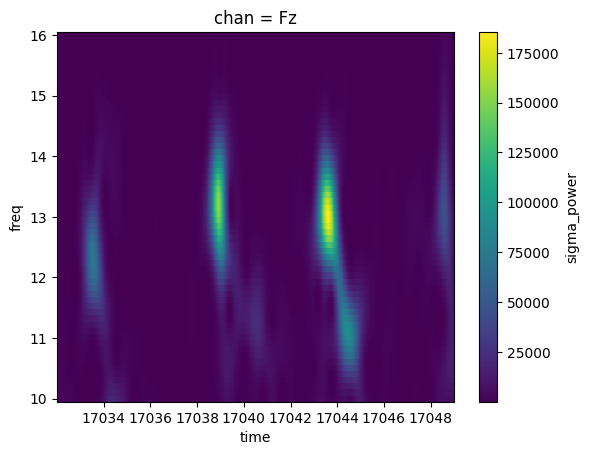

In [41]:
tf.sel(chan = chan, time = slice(t_init, t_end)).plot()

In [42]:
tf_slice = tf.sel(chan = chan, time = slice(t_init, t_end))
resp_slice = resp_filt.sel(time = slice(t_init, t_end))

In [43]:
f = tf_slice.coords['freq'].values
t = tf_slice.coords['time'].values
data = tf_slice.values
rsp = resp_slice.values
rsp = -gh.norm(rsp)

In [44]:
cycles = physio.detect_respiration_cycles(rsp, srate, baseline_mode='median')

In [45]:
features = physio.compute_respiration_cycle_features(rsp, srate, cycles)
features[['inspi_time','expi_time','next_inspi_time']] = features[['inspi_time','expi_time','next_inspi_time']].values + t_init
i_x = features['inspi_index']
e_x = features['expi_index']

i_t = features['inspi_time']
e_t = features['expi_time']

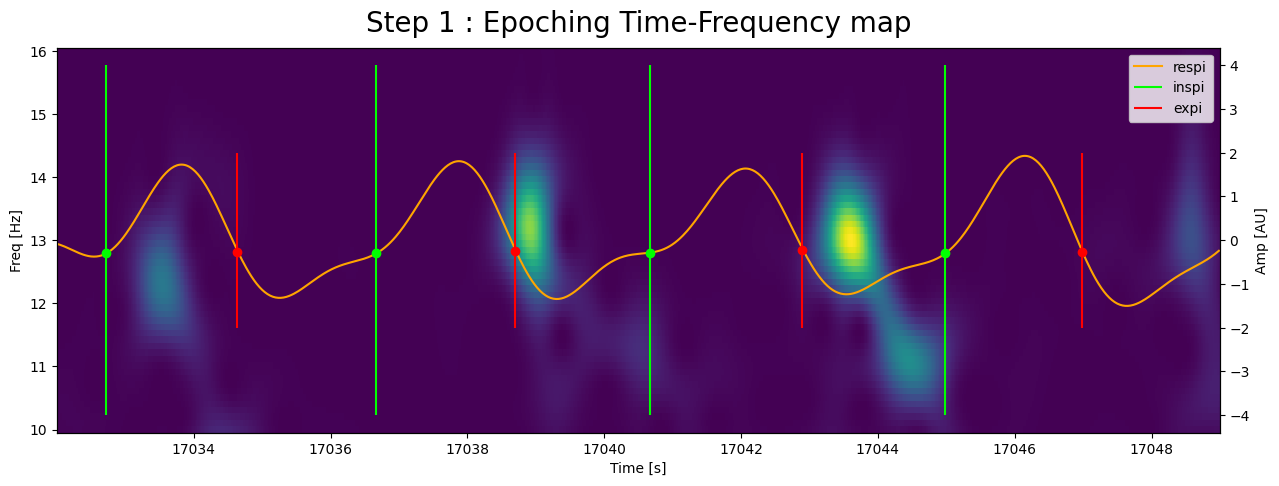

In [46]:
fig, ax = plt.subplots(figsize = (15,5))
ax.set_title('Step 1 : Epoching Time-Frequency map', fontsize = 20, y = 1.02)
ax.pcolormesh(t, f , data)
ax.set_ylabel('Freq [Hz]')
ax.set_xlabel('Time [s]')
ax2 = ax.twinx()
ax2.plot(t, -rsp, color = 'orange', label = 'respi')
ax2.plot(i_t, -rsp[i_x],'o', color = 'lime')
ax2.plot(e_t, -rsp[e_x],'o', color = 'red')
ax2.vlines(x=i_t, ymin = -4, ymax = 4, color = 'lime', label = 'inspi')
ax2.vlines(x=e_t, ymin = -2, ymax = 2, color = 'red', label = 'expi')
ax2.set_ylabel('Amp [AU]')
ax2.legend()
if save:
    fig.savefig(article_folder / 'epoching_tf.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

In [47]:
cycle_times = features[['inspi_time','expi_time','next_inspi_time']]

In [48]:
deformed_data_stacked = physio.deform_traces_to_cycle_template(data.T, t , cycle_times.values , segment_ratios = 0.4, points_per_cycle = 1000)

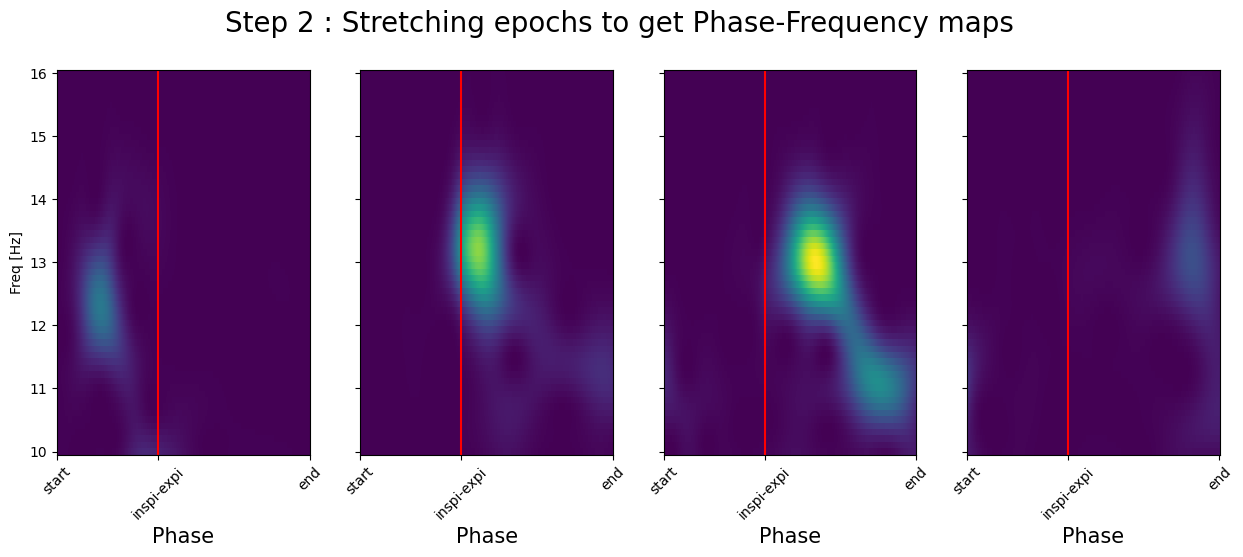

In [49]:
phase = np.linspace(0,1,1000)

fig, axs = plt.subplots(ncols = deformed_data_stacked.shape[0], sharey = True, figsize = (15,5))
fig.suptitle('Step 2 : Stretching epochs to get Phase-Frequency maps', fontsize = 20, y = 1.)

vmin = np.min(deformed_data_stacked)
vmax = np.max(deformed_data_stacked)

for c in range(deformed_data_stacked.shape[0]):
    ax = axs[c]
    ax.pcolormesh(phase, f, deformed_data_stacked[c,:,:].T, vmin=vmin, vmax=vmax)
    ax.axvline(x = 0.4, color = 'red')
    ax.set_xticks([0, 0.4 , 1])
    ax.set_xticklabels(['start','inspi-expi','end'], rotation = 45)
    if c == 0:
        ax.set_ylabel('Freq [Hz]')
    ax.set_xlabel('Phase', fontsize = 15)
if save:
    fig.savefig(article_folder / 'stretching.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

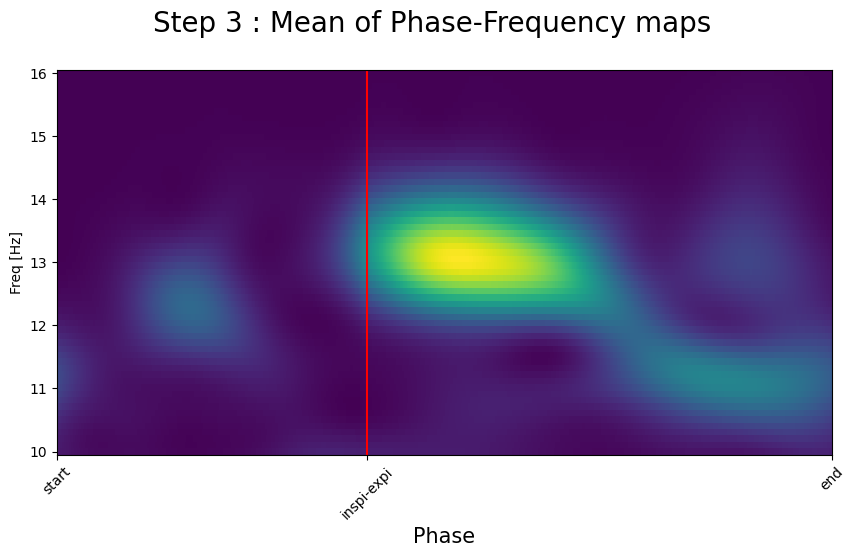

In [50]:
fig, ax = plt.subplots(figsize = (10,5))
fig.suptitle('Step 3 : Mean of Phase-Frequency maps', fontsize = 20, y = 1.)
ax.pcolormesh(phase, f, np.mean(deformed_data_stacked, axis = 0).T)
ax.axvline(x = 0.4, color = 'r')
ax.set_xticks([0, 0.4 , 1])
ax.set_xticklabels(['start','inspi-expi','end'], rotation = 45)
ax.set_ylabel('Freq [Hz]')
ax.set_xlabel('Phase', fontsize = 15)
if save:
    fig.savefig(article_folder / 'averaging.tif', dpi = 300, bbox_inches = 'tight')
plt.show()